# LSTM/Bi-LSTM Classifier
Exploring both Keras Tokenizer and GloVe

In [ ]:
# Following: https://medium.com/analytics-vidhya/multiclass-text-classification-using-deep-learning-f25b4b1010e5

import re
import tqdm
from nltk.corpus import stopwords
import nltk
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow_addons as tfa
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from PIL import Image 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
def draw_confusion_matrix(true, preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(
        conf_matx, 
        annot=True, 
        annot_kws={"size": 12},
        fmt='g', 
        cbar=False, 
        cmap="viridis"
    )
    plt.show()

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import tensorflow_addons as tfa
import tensorflow as tf

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

In [ ]:
# read data
df = pd.read_csv("raw_data/fulltrain.csv", names=["labels", "text"])
# load test set
test_df = pd.read_csv("raw_data/balancedtest.csv", names=["labels", "text"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48854 entries, 0 to 48853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  48854 non-null  int64 
 1   text    48854 non-null  object
dtypes: int64(1), object(1)
memory usage: 763.5+ KB


<Axes: ylabel='Frequency'>

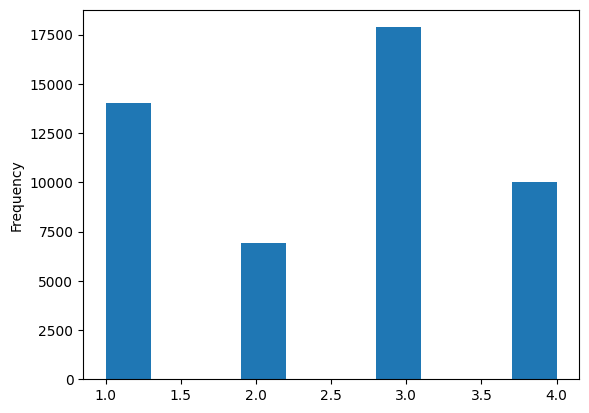

In [ ]:
df["labels"].plot(kind="hist")

In [ ]:
# Clean text
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['text'] = df['text'].apply(clean_text)


In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

GLOVE_DIR = f"glove/glove.6B.{EMBEDDING_DIM}d.txt"


tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 259286 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

X_test = tokenizer.texts_to_sequences(test_df['text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', X_test.shape)

Shape of data tensor: (48854, 250)
Shape of test data tensor: (3000, 250)


In [ ]:
Y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', Y.shape)

Y_test = pd.get_dummies(test_df['labels']).values
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (48854, 4)
Shape of label tensor: (3000, 4)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(43968, 250) (43968, 4)
(4886, 250) (4886, 4)


In [ ]:
# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, Y_train_ros= ros.fit_resample(X_train, Y_train)
# Check the number of records after over sampling
print('training: ', Y_train.sum(axis=0))
print('training ros: ', Y_train_ros.sum(axis=0))

training:  [12671  6244 16085  8968]
training ros:  [16085 16085 16085 16085]


In [ ]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, Y_train_rus= rus.fit_resample(X_train, Y_train)
# Check the number of records after under sampling
print('training: ', Y_train.sum(axis=0))
print('training rus: ', Y_train_rus.sum(axis=0))

training:  [12671  6244 16085  8968]
training rus:  [6244 6244 6244 6244]


In [ ]:
# Under sample the majority class
nearmiss = NearMiss(version=3)
X_train_nearmiss, Y_train_nearmiss= nearmiss.fit_resample(X_train, Y_train)
# Check the number of records after over sampling
print('training: ', Y_train.sum(axis=0))
print('training nearmiss: ', Y_train_nearmiss.sum(axis=0))

/Users/maxx/miniconda3/envs/tensor2.9/lib/python3.10/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/Users/maxx/miniconda3/envs/tensor2.9/lib/python3.10/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


training:  [12671  6244 16085  8968]
training nearmiss:  [2339 6244 4098 1703]


/Users/maxx/miniconda3/envs/tensor2.9/lib/python3.10/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [ ]:
# create embedding matrix
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf8')
print(f"Loading Glove from: {GLOVE_DIR}")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("Completed!")

Loading Glove from: glove/glove.6B.100d.txt
Done.
 Proceeding with Embedding Matrix...
Completed!


In [ ]:
use_glove = True # True for GloVe, False for Keras Tokenizer
use_bi_lstm = True # True for Bi-LSTM, False for LSTM

model = Sequential() 
if use_glove: 
    model.add(Embedding(len(tokenizer.word_index) + 1,
        EMBEDDING_DIM,
        weights = [embedding_matrix],
        input_length = MAX_SEQUENCE_LENGTH,
        trainable=False,
        name = 'embeddings'))
else: 
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])) 
model.add(SpatialDropout1D(0.2))
if use_bi_lstm: 
    model.add(Bidirectional(LSTM(100))),
else: 
    model.add(LSTM(100, dropout=0.2))
model.add(Dense(100, activation='relu')),
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    "categorical_accuracy", 
    tf.keras.metrics.Precision(), 
    tf.keras.metrics.Recall(), 
    tf.keras.metrics.AUC(),
    tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_score_micro"), 
    tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_score_macro")
])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 250, 100)          25928700  
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train_nearmiss, Y_train_nearmiss, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_f1_score_macro', patience=3, min_delta=0.0001)])

Epoch 1/5
203/203 [==============================] - 30s 147ms/step - loss: 0.0712 - categorical_accuracy: 0.9750 - precision_3: 0.9782 - recall_3: 0.9727 - auc_3: 0.9986 - f1_score_micro: 0.9750 - f1_score_macro: 0.9441 - val_loss: 2.3890 - val_categorical_accuracy: 0.5129 - val_precision_3: 0.5192 - val_recall_3: 0.5073 - val_auc_3: 0.7479 - val_f1_score_micro: 0.5129 - val_f1_score_macro: 0.1695
Epoch 2/5
203/203 [==============================] - 29s 144ms/step - loss: 0.0649 - categorical_accuracy: 0.9771 - precision_3: 0.9797 - recall_3: 0.9746 - auc_3: 0.9989 - f1_score_micro: 0.9771 - f1_score_macro: 0.9515 - val_loss: 2.2625 - val_categorical_accuracy: 0.5149 - val_precision_3: 0.5201 - val_recall_3: 0.5038 - val_auc_3: 0.7329 - val_f1_score_micro: 0.5149 - val_f1_score_macro: 0.1700
Epoch 3/5
203/203 [==============================] - 32s 157ms/step - loss: 0.0624 - categorical_accuracy: 0.9792 - precision_3: 0.9809 - recall_3: 0.9778 - auc_3: 0.9990 - f1_score_micro: 0.9792 

In [ ]:
results = model.evaluate(X_val, Y_val, batch_size=64)
print('Eval loss:', results[0])
print('Eval categorical_accuracy:', results[1])
print('Eval precision:', results[2])
print('Eval recall:', results[3])
print('Eval auc:', results[4])
print('Eval F1 (micro):', results[5])
print('Eval F1 (macro):', results[6])

77/77 [==============================] - 7s 89ms/step - loss: 0.4577 - categorical_accuracy: 0.8749 - precision_3: 0.8801 - recall_3: 0.8711 - auc_3: 0.9709 - f1_score_micro: 0.8749 - f1_score_macro: 0.8582
Eval loss: 0.45769357681274414
Eval categorical_accuracy: 0.8749488592147827
Eval precision: 0.8800661563873291
Eval recall: 0.8710601925849915
Eval auc: 0.9708582162857056
Eval F1 (micro): 0.8749489188194275
Eval F1 (macro): 0.8581573963165283


START predict
94/94 [==============================] - 7s 68ms/step
DONE predict
START evaluate
94/94 [==============================] - 8s 85ms/step - loss: 1.7922 - categorical_accuracy: 0.5930 - precision_3: 0.6004 - recall_3: 0.5790 - auc_3: 0.8044 - f1_score_micro: 0.5930 - f1_score_macro: 0.5942
Test loss: 1.7922228574752808
Test categorical_accuracy: 0.5929999947547913
Test precision: 0.6004148125648499
Test recall: 0.5789999961853027
Test auc: 0.8043859601020813
Test F1 (micro): 0.5929999947547913
Test F1 (macro): 0.5942159295082092


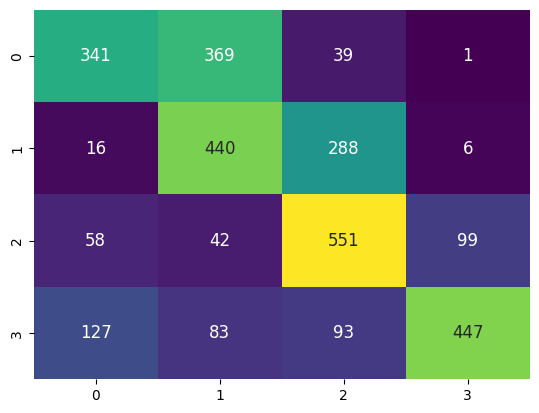

In [ ]:
# predict
print("START predict")
test_predictions = model.predict(X_test)
test_result = np.argmax(test_predictions, axis=1)
print("DONE predict")

# evaluate
print("START evaluate")
test_results = model.evaluate(X_test, Y_test)
print('Test loss:', test_results[0])
print('Test categorical_accuracy:', test_results[1])
print('Test precision:', test_results[2])
print('Test recall:', test_results[3])
print('Test auc:', test_results[4])
print('Test F1 (micro):', test_results[5])
print('Test F1 (macro):', test_results[6])

draw_confusion_matrix(np.argmax(Y_test, axis=1), test_result)

In [ ]:
model.save("bi-lstm_model_best")

INFO:tensorflow:Assets written to: bi-lstm_model_best/assets


INFO:tensorflow:Assets written to: bi-lstm_model_best/assets
